In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from IPython import display
import scipy as sp
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

%matplotlib inline

In [182]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore')

# Suppress only ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [8]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

### Loading dataset

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Variable description

| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |	
| sibsp | # of siblings / spouses aboard the Titanic | |	
| parch | # of parents / children aboard the Titanic | |	
| ticket | Ticket number | |	
| fare | Passenger fare | |	
| cabin | Cabin number | |	
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

#### Explanation - 

1. Survived - dependent variable
2. PassengerID and Ticket - no impact on the outcome variable - excluded.
3. Pclass - ordinal variable - upper,middle,low class
4. Name - can be used in feature engineering - age bucket from titles.
5. Sex and Embarked - nominal
6. Age and Fare - continuous quantitative 
7. SibSp - number of related siblings/spouse
8. Parch - number of related parents/children aboard
9. Cabin - nominal - majority variables NULL - excluded.


##### Categorical - Cabin, Embarked, Sex, Pclass 
##### Numeric - Passenger ID, SibSp, Parch, Age, Fare

In [10]:
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [11]:
train.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Finding outliers

In [25]:
boundary = '-'*55

In [31]:
import numpy as np
from collections import Counter


def find_extreme_data_points(dataframe, threshold, columns):
    """
    Identify observations with multiple extreme data points using the Tukey method.

    This function analyzes specified columns in a DataFrame to detect extreme values
    (outliers) based on the interquartile range (IQR). It then identifies observations
    that have more than a specified number of extreme values across these columns.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame to analyze.
        threshold (int): The minimum number of extreme values an observation must have
                         to be considered an outlier.
        columns (list): A list of column names to check for extreme values.

    Returns:
        list: Indices of observations that have more than 'threshold' extreme values.
    """
    extreme_indices = []

    for column in columns:
        print(boundary)
        q1 = np.percentile(dataframe[column], 25)
        q3 = np.percentile(dataframe[column], 75)
        iqr = q3 - q1
        print(f'q1: {q1} \t q3: {q3}')
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        print(f'lower_bound: {lower_bound} \t upper_bound: {upper_bound}')
        
        column_extremes = dataframe[
            (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
        ].index

        print(f'{column}: Indices: [{column_extremes}]')
        extreme_indices.extend(column_extremes)

    extreme_counts = Counter(extreme_indices)
    multi_extreme_indices = [
        index for index, count in extreme_counts.items() if count > threshold
    ]

    print(boundary)
    print(f'Extreme Counts: {extreme_counts}')
    print(boundary)
    
    return multi_extreme_indices


# Example usage:
extreme_data = find_extreme_data_points(train, 2, ["Age", "SibSp", "Parch", "Fare"])

-------------------------------------------------------
q1: nan 	 q3: nan
lower_bound: nan 	 upper_bound: nan
Age: Indices: [Index([], dtype='int64')]
-------------------------------------------------------
q1: 0.0 	 q3: 1.0
lower_bound: -1.5 	 upper_bound: 2.5
SibSp: Indices: [Index([  7,  16,  24,  27,  50,  59,  63,  68,  71,  85,  88, 119, 159, 164,
       171, 176, 180, 182, 201, 229, 233, 261, 266, 278, 324, 341, 374, 386,
       409, 480, 485, 541, 542, 634, 642, 683, 686, 726, 787, 792, 813, 819,
       824, 846, 850, 863],
      dtype='int64')]
-------------------------------------------------------
q1: 0.0 	 q3: 0.0
lower_bound: 0.0 	 upper_bound: 0.0
Parch: Indices: [Index([  7,   8,  10,  13,  16,  24,  25,  27,  43,  50,
       ...
       855, 856, 858, 863, 869, 871, 879, 880, 885, 888],
      dtype='int64', length=213)]
-------------------------------------------------------
q1: 7.9104 	 q3: 31.0
lower_bound: -26.724 	 upper_bound: 65.6344
Fare: Indices: [Index([  1,  27

In [34]:
example = pd.DataFrame({'A': [1, 2, 100, 4, 5], 'B': [10, 20, 30, 400, 50]})
find_extreme_data_points(example, 0, ['A', 'B'])

-------------------------------------------------------
q1: 2.0 	 q3: 5.0
lower_bound: -2.5 	 upper_bound: 9.5
A: Indices: [Index([2], dtype='int64')]
-------------------------------------------------------
q1: 20.0 	 q3: 50.0
lower_bound: -25.0 	 upper_bound: 95.0
B: Indices: [Index([3], dtype='int64')]
-------------------------------------------------------
Extreme Counts: Counter({2: 1, 3: 1})
-------------------------------------------------------


[2, 3]

In [35]:
train.loc[extreme_data]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [37]:
# Remove extreme data points and reset the index
print(f'Before: {len(train)}')
train = train.drop(extreme_data, axis=0).reset_index(drop=True)
print(f'After: {len(train)}')

Before: 891
After: 881


In [38]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
# Display the number of missing values in each column
print("\nMissing Values:")
print(train.isnull().sum())


Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64


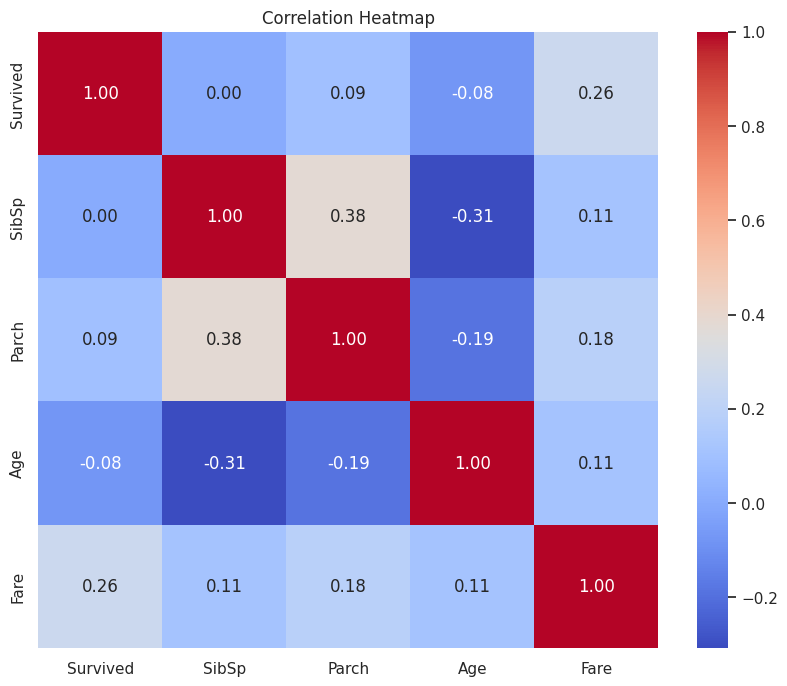

In [40]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Key Insights

## Survival and Fare
- The strongest positive correlation with survival (0.26) is the fare paid.
- This suggests that passengers who paid higher fares had a better chance of surviving.
- This could be indicative of class differences, as higher fares likely correspond to better accommodations and possibly prioritized access to lifeboats.

## Survival and Age
- There's a weak negative correlation (-0.08) between age and survival.
- This implies that younger passengers had a slightly better chance of surviving, though the relationship is not strong.
- The "women and children first" protocol might explain this weak negative correlation.

## Family Relationships
- SibSp (siblings/spouses) and Parch (parents/children) have a moderate positive correlation (0.38).
    - Larger families would have higher numbers in both categories.
- Parch has a slightly stronger positive correlation with survival (0.09) compared to SibSp (0.003).
    - This might suggest that having parents or children onboard slightly increased survival chances, while siblings or spouses had negligible impact.

## Age and Family Size
- Age has a negative correlation with both SibSp (-0.307) and Parch (-0.186).
    - Younger passengers were more likely to be traveling with family members.
    - The stronger negative correlation with SibSp suggests that younger passengers were more often traveling with siblings than with parents or children.

## Fare and Family Relationships
- Fare has a weak positive correlation with both SibSp (0.110) and Parch (0.184).
    - Larger family groups tended to pay slightly higher fares, possibly due to booking larger or multiple cabins.

## Age and Fare
- There's a weak positive correlation (0.110) between age and fare.
    - Older passengers tended to pay slightly higher fares, possibly due to booking better accommodations or traveling in higher classes.

### Notes
- The fare paid appears to be the most significant factor correlated with survival.
    - Further investigation into the relationship between fare, passenger class, and survival is warranted.
- While age shows a weak negative correlation with survival, its relationship with family size and fare suggests more complex interactions.
    - A more detailed analysis of age groups and their survival rates could provide additional insights.
- The difference in correlation between SibSp and Parch with survival is intriguing.
    - It might be worth investigating whether certain family compositions had better survival rates.
- Given the correlations observed, creating interaction features (e.g., combining age with fare or family size) could potentially improve predictive models for survival.
- While these correlations

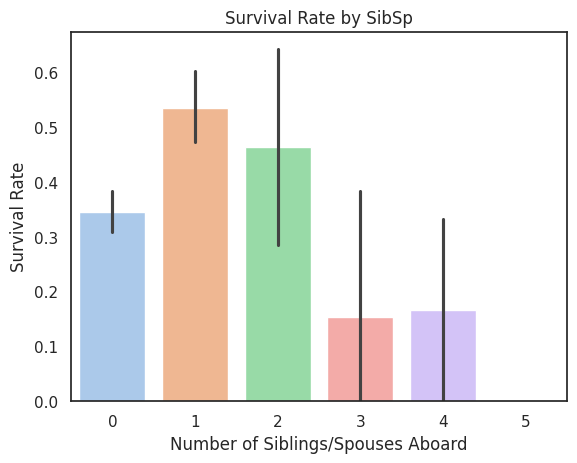

In [48]:
# Bar plot showing average survival rate for each SibSp value
sns.barplot(x="SibSp", y="Survived", data=train, palette='pastel')

# Add labels and title
plt.title("Survival Rate by SibSp")
plt.xlabel("Number of Siblings/Spouses Aboard")
plt.ylabel("Survival Rate")
plt.show()

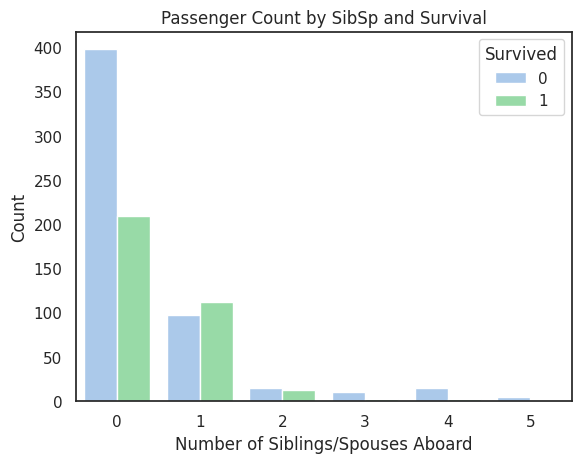

In [57]:
# Count plot showing the count of passengers based on SibSp and survival
sns.countplot(x="SibSp", hue="Survived", data=train, palette='pastel6')

# Add labels and title
plt.title("Passenger Count by SibSp and Survival")
plt.xlabel("Number of Siblings/Spouses Aboard")
plt.ylabel("Count")
plt.show()

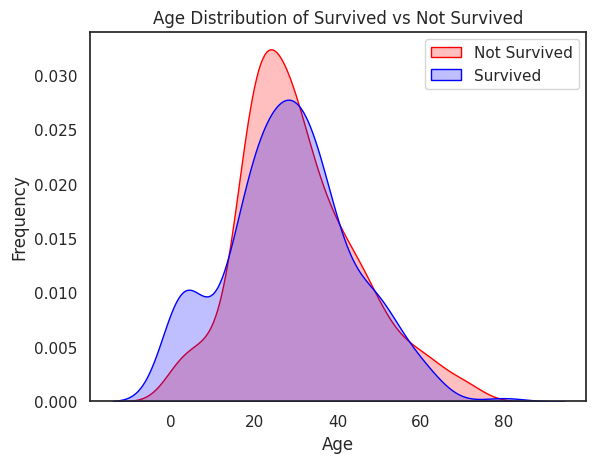

In [59]:
# Plot Age distribution for non-survived and survived passengers
g = sns.kdeplot(
    train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], 
    color="Red", shade=True
)
g = sns.kdeplot(
    train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], 
    ax=g, color="Blue", shade=True
)

# Set labels for axes
g.set_xlabel("Age")
g.set_ylabel("Frequency")

# Add legend
g = g.legend(["Not Survived", "Survived"])

# Show the plot
plt.title("Age Distribution of Survived vs Not Survived")
plt.show()

Number of missing Fare values: 0


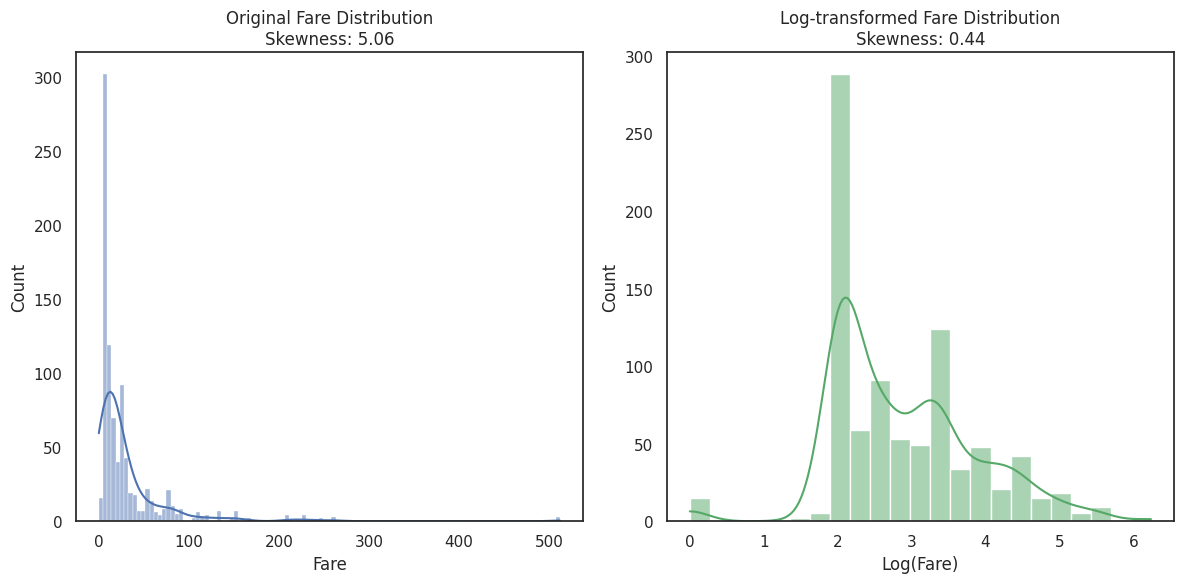

In [61]:
def preprocess_fare(dataset):
    """
    Preprocess the 'Fare' column:
    1. Handle missing values
    2. Apply log transformation to reduce skewness
    3. Visualize the distribution before and after transformation
    
    Args:
    dataset (pd.DataFrame): The dataset containing the 'Fare' column
    
    Returns:
    pd.DataFrame: The dataset with preprocessed 'Fare' column
    """
    # Check for missing values
    missing_fares = dataset["Fare"].isnull().sum()
    print(f"Number of missing Fare values: {missing_fares}")

    # Fill missing values with median
    dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

    # Visualize original distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(dataset["Fare"], kde=True, color="b")
    plt.title(f"Original Fare Distribution\nSkewness: {dataset['Fare'].skew():.2f}")
    plt.xlabel("Fare")

    # Apply log transformation
    dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

    # Visualize transformed distribution
    plt.subplot(1, 2, 2)
    sns.histplot(dataset["Fare"], kde=True, color="g")
    plt.title(f"Log-transformed Fare Distribution\nSkewness: {dataset['Fare'].skew():.2f}")
    plt.xlabel("Log(Fare)")

    plt.tight_layout()
    plt.show()

    return dataset

train = preprocess_fare(train)

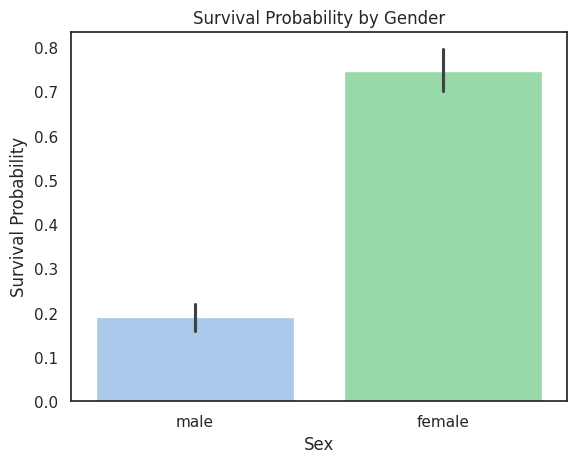

,Survived
Sex,
female,0.747573
male,0.190559


In [64]:
# Bar plot showing survival probability by gender
g = sns.barplot(x="Sex", y="Survived", data=train,palette='pastel6')
g = g.set_ylabel("Survival Probability")

# Display the plot
plt.title("Survival Probability by Gender")
plt.show()

# Display the mean survival rate for each gender
train[["Sex", "Survived"]].groupby('Sex').mean()

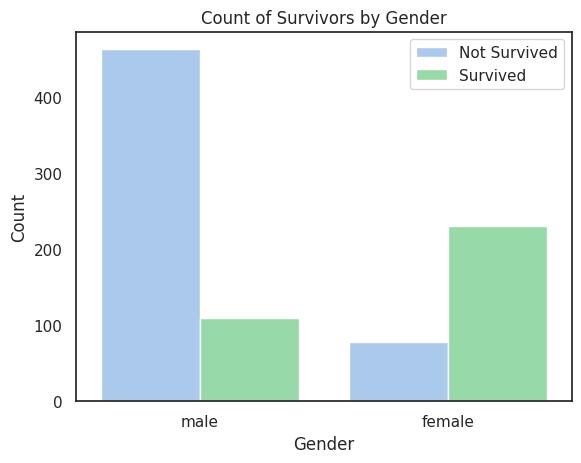

In [65]:
sns.countplot(x="Sex", hue="Survived", data=train, palette='pastel6')

# Add labels and title
plt.title("Count of Survivors by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(["Not Survived", "Survived"])

# Display the plot
plt.show()

# Survival Based on Gender

The gender of the passengers seems to play a significant role in survival. As per the well-known phrase from the Titanic movie, **"Women and children first,"** it's clear that gender could be a key factor in survival rates.

- Gender plays a crucial role in survival, and this should be a key feature in predictive models for survival.
- The Titanic's evacuation protocol likely led to the stark differences in survival rates between males and females.

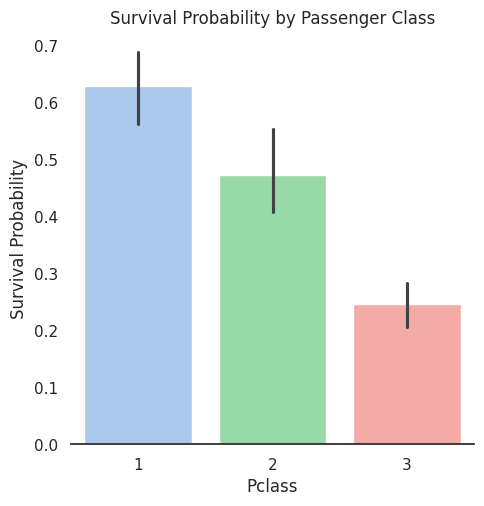

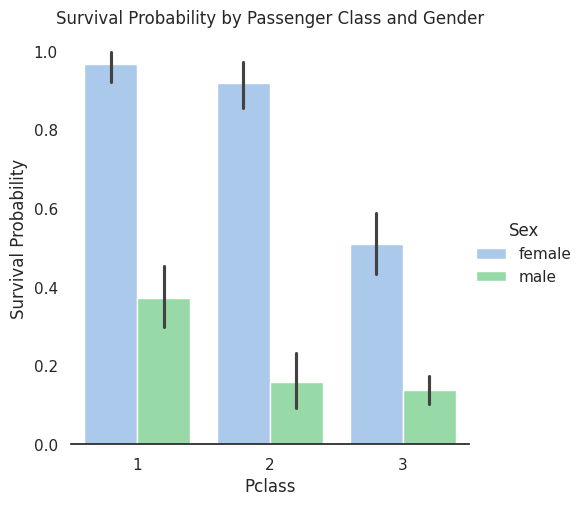

In [70]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", palette="pastel6")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")
plt.title("Survival Probability by Passenger Class")
plt.show()

# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar", palette="pastel6")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")
plt.title("Survival Probability by Passenger Class and Gender")
plt.show()

- **Passenger Class** plays a significant role in survival. First-class passengers had a better chance of surviving than second and third-class passengers.
- This trend remains consistent when looking at both male and female passengers.

In [73]:
# Fill missing values in 'Embarked' with the most frequent value
most_frequent_value = train["Embarked"].mode()[0]
print(f"The most frequent value for 'Embarked' is: {most_frequent_value}")
train["Embarked"] = train["Embarked"].fillna(most_frequent_value)

The most frequent value for 'Embarked' is: S


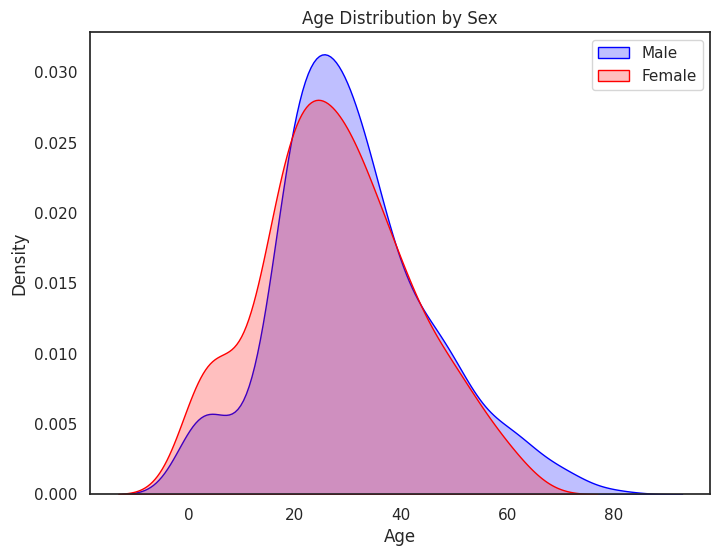

In [74]:
# Plot Age distribution for male and female passengers
plt.figure(figsize=(8, 6))
sns.kdeplot(train["Age"][train["Sex"] == 'male'], color="Blue", shade=True, label="Male")
sns.kdeplot(train["Age"][train["Sex"] == 'female'], color="Red", shade=True, label="Female")

# Add labels and title
plt.title("Age Distribution by Sex")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.show()

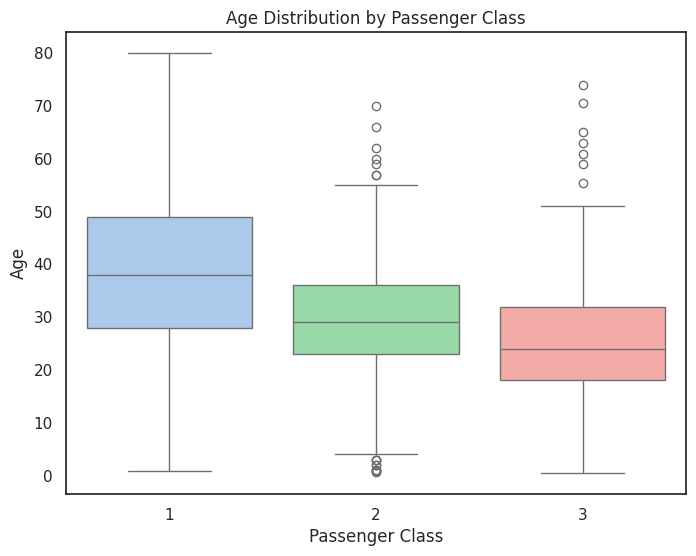

In [76]:
# Plot Age distribution by passenger class
plt.figure(figsize=(8, 6))
sns.boxplot(x="Pclass", y="Age", data=train, palette="pastel6")

# Add labels and title
plt.title("Age Distribution by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()

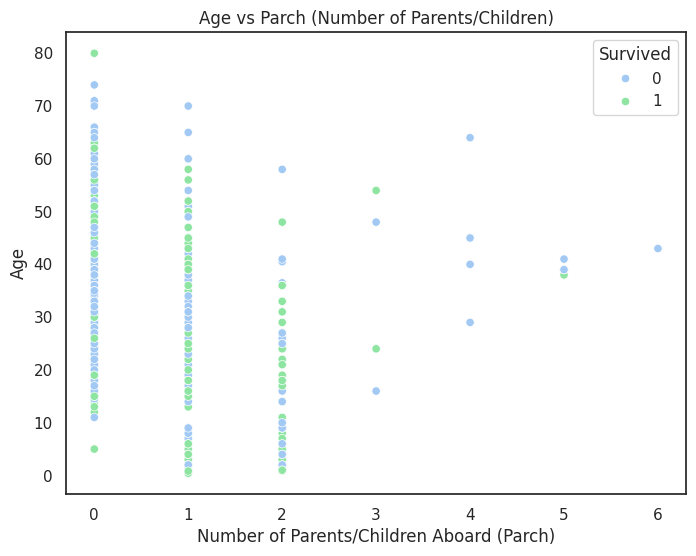

In [77]:
# Scatter plot of Age vs Parch
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Parch", y="Age", data=train, hue="Survived", palette="pastel6")

# Add labels and title
plt.title("Age vs Parch (Number of Parents/Children)")
plt.xlabel("Number of Parents/Children Aboard (Parch)")
plt.ylabel("Age")
plt.show()

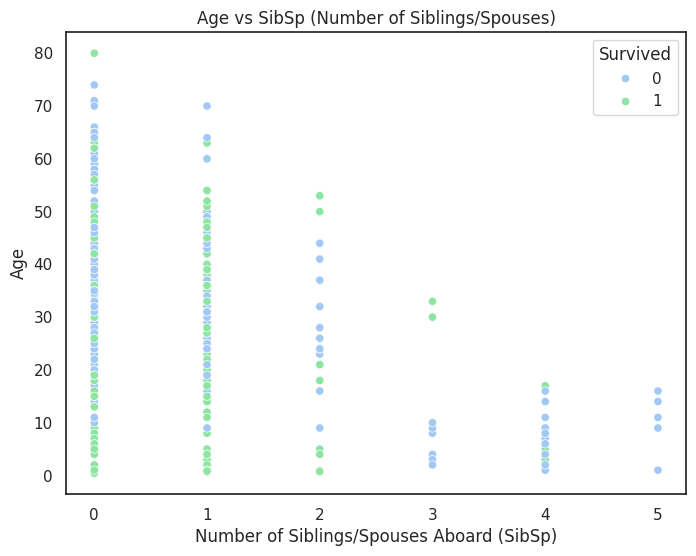

In [78]:
# Scatter plot of Age vs SibSp
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SibSp", y="Age", data=train, hue="Survived", palette="pastel6")

# Add labels and title
plt.title("Age vs SibSp (Number of Siblings/Spouses)")
plt.xlabel("Number of Siblings/Spouses Aboard (SibSp)")
plt.ylabel("Age")
plt.show()

- **Age by Sex**: The age distribution is similar for males and females, indicating that Sex is not highly informative in predicting Age.
  
- **Age by Pclass**: First-class passengers tend to be older, followed by second-class, and then third-class passengers.
  
- **Age vs Parch**: A higher number of parents or children aboard tends to be correlated with older passengers.
  
- **Age vs SibSp**: Passengers with more siblings or spouses aboard tend to be younger.


In [81]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(train["Age"][train["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train["Age"].median()
    age_pred = train["Age"][((train['SibSp'] == train.iloc[i]["SibSp"]) & (train['Parch'] == train.iloc[i]["Parch"]) & (train['Pclass'] == train.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        train['Age'].iloc[i] = age_pred
    else :
        train['Age'].iloc[i] = age_med

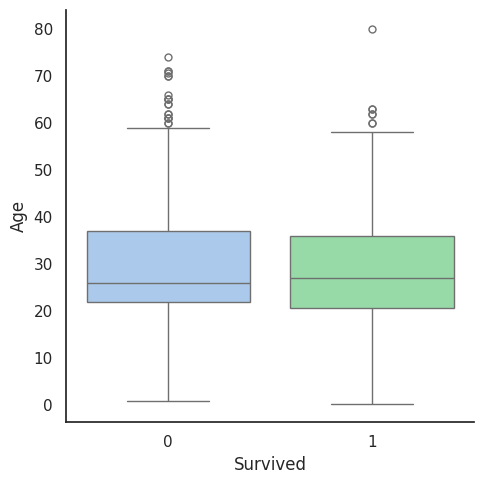

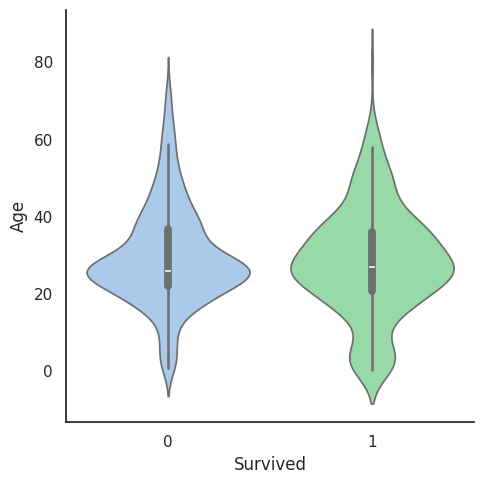

In [82]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box", palette="pastel6")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin", palette="pastel6")

# Feature Engineering

In [84]:
train["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

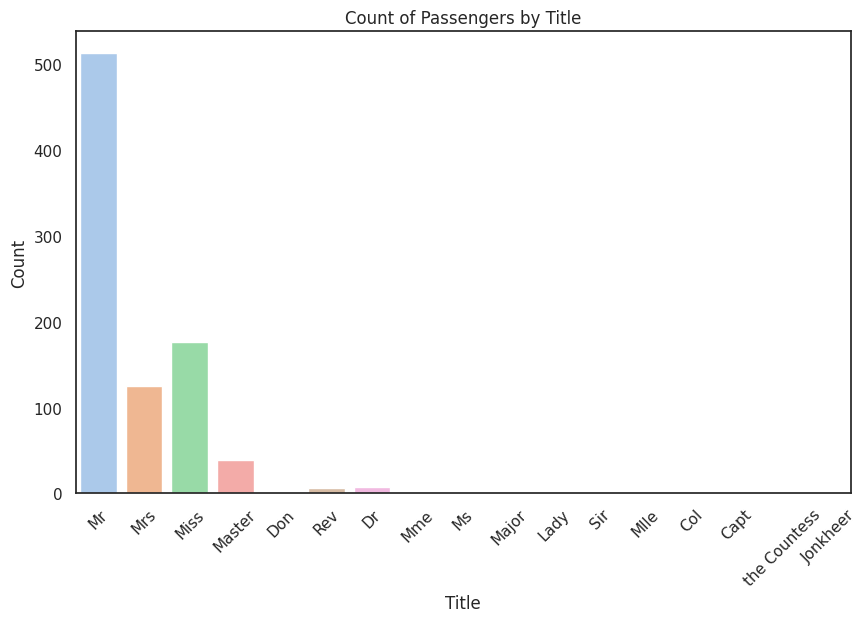

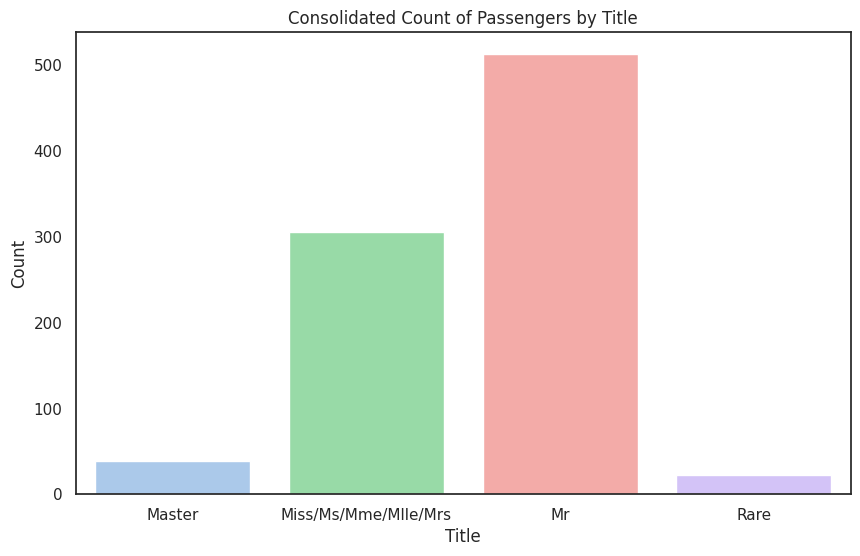

In [85]:
# Extract Titles from Name
train["Title"] = train["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

# Visualize Title Counts
plt.figure(figsize=(10, 6))
g = sns.countplot(x="Title", data=train, palette='pastel')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_title('Count of Passengers by Title')
g.set_ylabel('Count')
plt.show()

# Consolidate Titles into Categories
rare_titles = ['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train["Title"] = train["Title"].replace(rare_titles, 'Rare')

# Map Titles to Numeric Values
title_mapping = {
    "Master": 0,
    "Miss": 1,
    "Ms": 1,
    "Mme": 1,
    "Mlle": 1,
    "Mrs": 1,
    "Mr": 2,
    "Rare": 3
}
train["Title"] = train["Title"].map(title_mapping).astype(int)

# Visualize the Consolidated Title Counts
plt.figure(figsize=(10, 6))
g = sns.countplot(x=train["Title"], palette='pastel6')
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
g.set_title('Consolidated Count of Passengers by Title')
g.set_ylabel('Count')
plt.show()

In [87]:
# Drop Name variable
train.drop(labels = ["Name"], axis = 1, inplace = True)

<Figure size 1000x600 with 0 Axes>

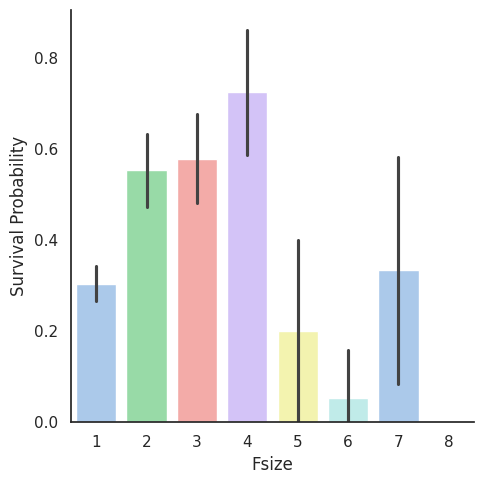

In [92]:
train["Fsize"] = train["SibSp"] + train["Parch"] + 1

# Plotting the survival probability based on family size
plt.figure(figsize=(10, 6))
g = sns.catplot(x="Fsize", y="Survived", data=train, kind="bar", palette='pastel6')
g.set_ylabels("Survival Probability")
plt.show()

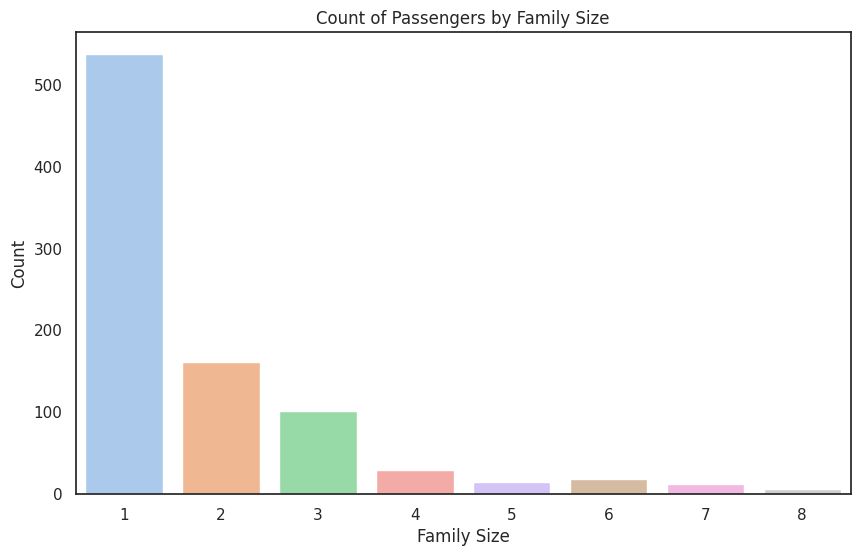

In [93]:
# Count Plot
plt.figure(figsize=(10, 6))
sns.countplot(x="Fsize", data=train, palette='pastel')
plt.title('Count of Passengers by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Count')
plt.show()

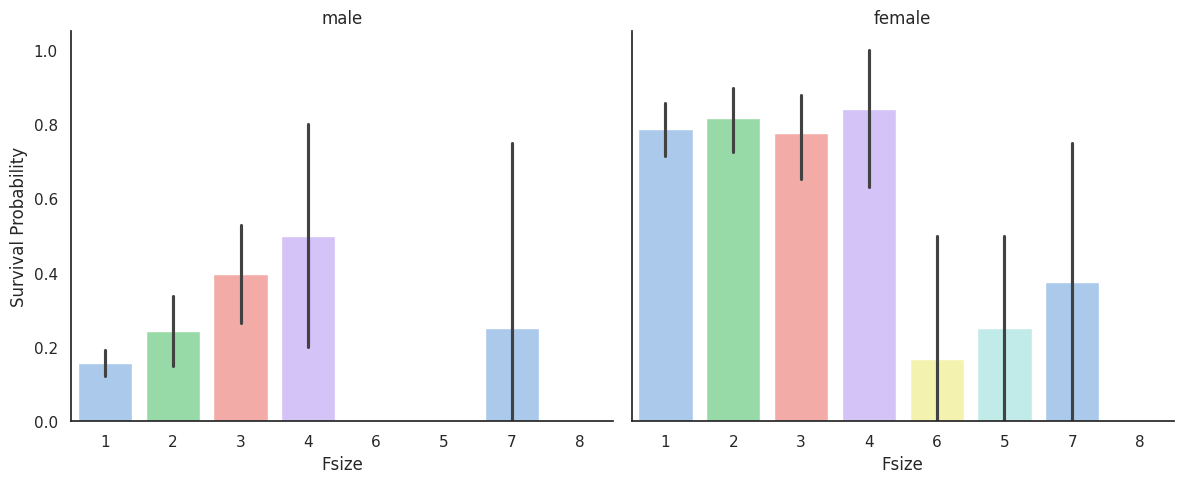

In [96]:
g = sns.FacetGrid(train, col='Sex', height=5, aspect=1.2)
g.map(sns.barplot, 'Fsize', 'Survived', order=train['Fsize'].value_counts().index, palette='pastel6')
g.set_titles('{col_name}')
g.set_ylabels("Survival Probability")
plt.show()

<Figure size 800x500 with 0 Axes>

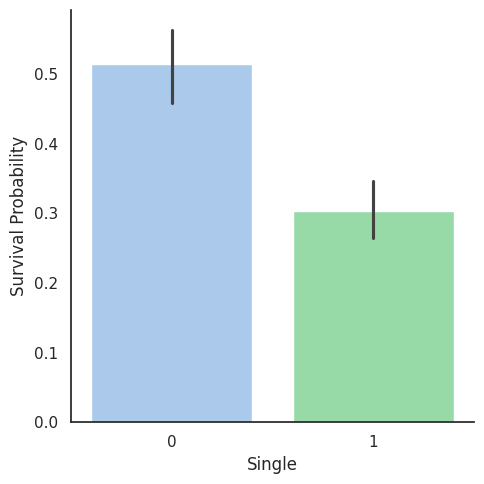

<Figure size 800x500 with 0 Axes>

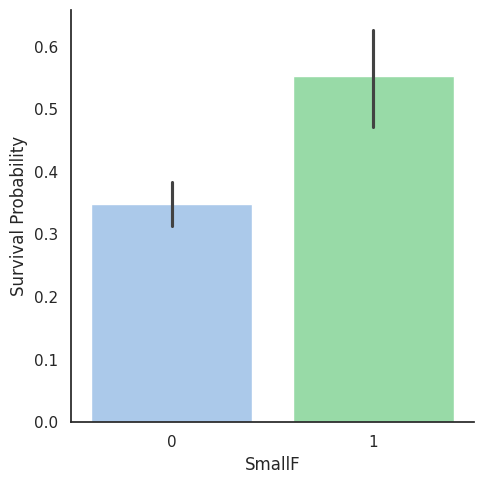

<Figure size 800x500 with 0 Axes>

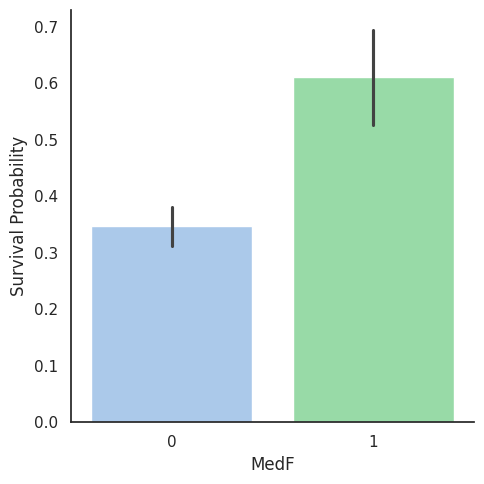

<Figure size 800x500 with 0 Axes>

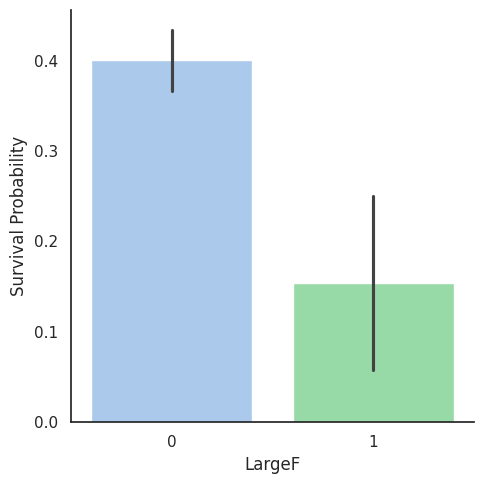

In [98]:
# Create new features for family size categories
train['Single'] = train['Fsize'].map(lambda s: 1 if s == 1 else 0)  # Single passenger
train['SmallF'] = train['Fsize'].map(lambda s: 1 if s == 2 else 0)  # Small family (2 members)
train['MedF'] = train['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)  # Medium family (3-4 members)
train['LargeF'] = train['Fsize'].map(lambda s: 1 if s >= 5 else 0)  # Large family (5 or more members)

# List of family size categories for plotting
family_categories = ['Single', 'SmallF', 'MedF', 'LargeF']

# Create a bar plot for each family size category and their survival probability
for category in family_categories:
    plt.figure(figsize=(8, 5))
    g = sns.catplot(x=category, y="Survived", data=train, kind="bar", palette='pastel6')
    g.set_ylabels("Survival Probability")
    # g.set_title(f'Survival Probability for {category} Family Size')
    plt.show()


In [99]:
# convert to indicator values Title and Embarked 
train = pd.get_dummies(train, columns = ["Title"])
train = pd.get_dummies(train, columns = ["Embarked"], prefix="Em")

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0,3,male,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1,1,female,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1,1,female,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0,3,male,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


In [101]:
train["Cabin"].describe()

count         201
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [102]:
train["Cabin"].isnull().sum()

680

In [103]:
train["Cabin"][train["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

<Axes: xlabel='count', ylabel='Cabin'>

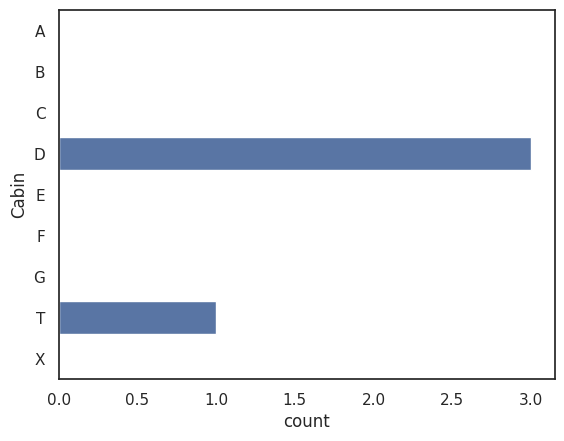

In [107]:
sns.countplot(train["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

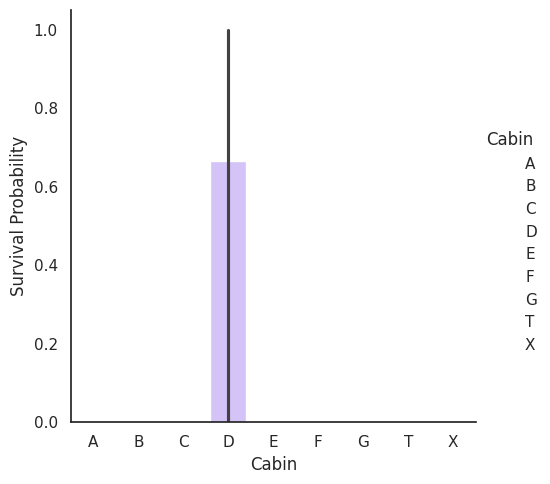

In [105]:
g = sns.catplot(y="Survived",x="Cabin",data=train,kind="bar",order=['A','B','C','D','E','F','G','T','X'],palette='pastel6')
g = g.set_ylabels("Survival Probability")

In [108]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0,3,male,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1,1,female,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1,1,female,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0,3,male,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


-------------------------------------------------------
q1: nan 	 q3: nan
lower_bound: nan 	 upper_bound: nan
Age: Indices: [Index([], dtype='int64')]
-------------------------------------------------------
q1: 0.0 	 q3: 1.0
lower_bound: -1.5 	 upper_bound: 2.5
SibSp: Indices: [Index([53, 55, 140, 145, 154, 188, 214, 360, 379, 389, 394], dtype='int64')]
-------------------------------------------------------
q1: 0.0 	 q3: 0.0
lower_bound: 0.0 	 upper_bound: 0.0
Parch: Indices: [Index([  4,   7,  21,  23,  24,  26,  32,  33,  40,  49,  52,  53,  55,  64,
        69,  80,  89,  92, 104, 117, 125, 132, 139, 140, 142, 149, 150, 153,
       154, 159, 161, 165, 167, 174, 175, 178, 179, 181, 184, 186, 188, 192,
       194, 196, 201, 203, 214, 217, 218, 225, 238, 241, 242, 244, 247, 250,
       262, 263, 281, 283, 284, 293, 296, 302, 305, 306, 307, 308, 326, 330,
       333, 337, 342, 343, 344, 350, 353, 354, 360, 361, 365, 368, 374, 379,
       385, 389, 391, 392, 394, 397, 402, 407, 409, 417

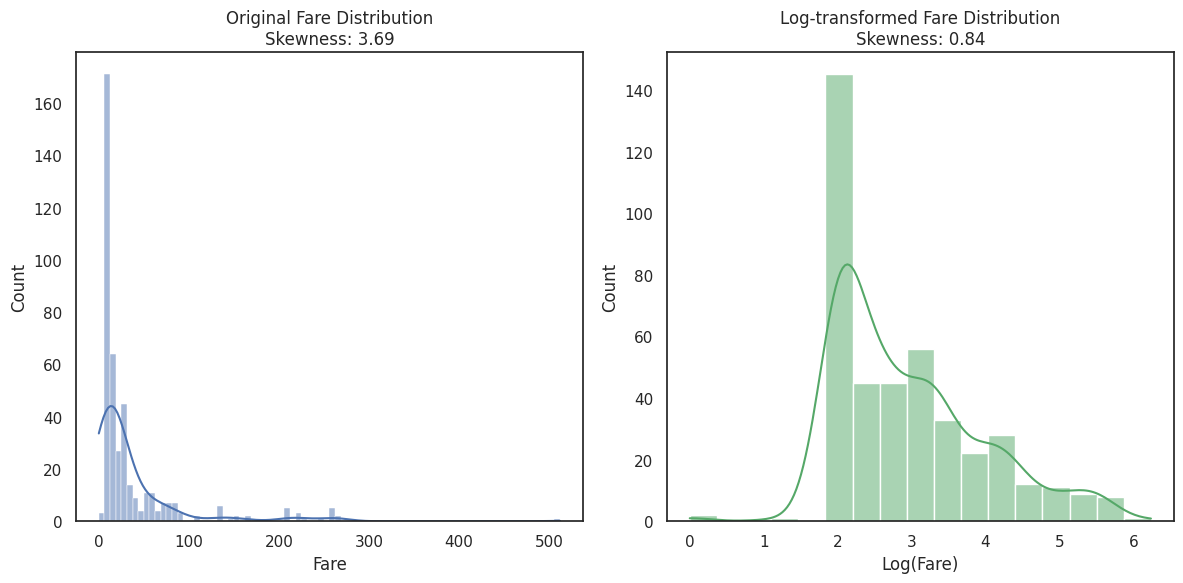

The most frequent value for 'Embarked' is: S


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,892,3,male,34.5,0,0,330911,2.057860,NaN,1,...,0,0,0,False,False,True,False,False,True,False
1,893,3,female,47.0,1,0,363272,1.945910,NaN,2,...,1,0,0,False,True,False,False,False,False,True
2,894,2,male,62.0,0,0,240276,2.270836,NaN,1,...,0,0,0,False,False,True,False,False,True,False
3,895,3,male,27.0,0,0,315154,2.159003,NaN,1,...,0,0,0,False,False,True,False,False,False,True
4,896,3,female,22.0,1,1,3101298,2.508582,NaN,3,...,0,1,0,False,True,False,False,False,False,True


In [110]:
extreme_data = find_extreme_data_points(test, 2, ["Age", "SibSp", "Parch", "Fare"])
# Remove extreme data points and reset the index
print(f'Before: {len(test)}')
test = test.drop(extreme_data, axis=0).reset_index(drop=True)
print(f'After: {len(test)}')
test = preprocess_fare(test)

# Fill missing values in 'Embarked' with the most frequent value
most_frequent_value = test["Embarked"].mode()[0]
print(f"The most frequent value for 'Embarked' is: {most_frequent_value}")
test["Embarked"] = test["Embarked"].fillna(most_frequent_value)


index_NaN_age = list(test["Age"][test["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = test["Age"].median()
    age_pred = test["Age"][((test['SibSp'] == test.iloc[i]["SibSp"]) & (test['Parch'] == test.iloc[i]["Parch"]) & (test['Pclass'] == test.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        test['Age'].iloc[i] = age_pred
    else :
        test['Age'].iloc[i] = age_med


test["Title"] = test["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())


# Consolidate Titles into Categories
rare_titles = ['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
test["Title"] = test["Title"].replace(rare_titles, 'Rare')

# Map Titles to Numeric Values
title_mapping = {
    "Master": 0,
    "Miss": 1,
    "Ms": 1,
    "Mme": 1,
    "Mlle": 1,
    "Mrs": 1,
    "Mr": 2,
    "Rare": 3
}
test["Title"] = test["Title"].map(title_mapping).astype(int)

test.drop(labels = ["Name"], axis = 1, inplace = True)
test["Fsize"] = test["SibSp"] + test["Parch"] + 1

test['Single'] = test['Fsize'].map(lambda s: 1 if s == 1 else 0)  # Single passenger
test['SmallF'] = test['Fsize'].map(lambda s: 1 if s == 2 else 0)  # Small family (2 members)
test['MedF'] = test['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)  # Medium family (3-4 members)
test['LargeF'] = test['Fsize'].map(lambda s: 1 if s >= 5 else 0)  # Large family (5 or more members)

test = pd.get_dummies(test, columns = ["Title"])
test = pd.get_dummies(test, columns = ["Embarked"], prefix="Em")
test.head()

In [112]:
train.Cabin.isna().sum(),len(train)

(680, 881)

In [113]:
test.Cabin.isna().sum(),len(test)

(327, 418)

In [114]:
# Dropping Cabin as most values are NaN, also dropping Ticket Column

In [116]:
test = test.drop(['Cabin', 'Ticket'], axis=1)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,892,3,male,34.5,0,0,2.057860,1,1,0,0,0,False,False,True,False,False,True,False
1,893,3,female,47.0,1,0,1.945910,2,0,1,0,0,False,True,False,False,False,False,True
2,894,2,male,62.0,0,0,2.270836,1,1,0,0,0,False,False,True,False,False,True,False
3,895,3,male,27.0,0,0,2.159003,1,1,0,0,0,False,False,True,False,False,False,True
4,896,3,female,22.0,1,1,2.508582,3,0,0,1,0,False,True,False,False,False,False,True


In [117]:
train = train.drop(['Cabin', 'Ticket'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0,3,male,22.0,1,0,1.981001,2,0,1,0,0,False,False,True,False,False,False,True
1,2,1,1,female,38.0,1,0,4.266662,2,0,1,0,0,False,True,False,False,True,False,False
2,3,1,3,female,26.0,0,0,2.070022,1,1,0,0,0,False,True,False,False,False,False,True
3,4,1,1,female,35.0,1,0,3.972177,2,0,1,0,0,False,True,False,False,False,False,True
4,5,0,3,male,35.0,0,0,2.085672,1,1,0,0,0,False,False,True,False,False,False,True


In [118]:
train["Pclass"] = train["Pclass"].astype("category")
train = pd.get_dummies(train, columns = ["Pclass"],prefix="Pc")
train.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,...,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,1,0,male,22.0,1,0,1.981001,2,0,1,...,False,False,True,False,False,False,True,False,False,True
1,2,1,female,38.0,1,0,4.266662,2,0,1,...,False,True,False,False,True,False,False,True,False,False
2,3,1,female,26.0,0,0,2.070022,1,1,0,...,False,True,False,False,False,False,True,False,False,True
3,4,1,female,35.0,1,0,3.972177,2,0,1,...,False,True,False,False,False,False,True,True,False,False
4,5,0,male,35.0,0,0,2.085672,1,1,0,...,False,False,True,False,False,False,True,False,False,True


In [119]:
test["Pclass"] = test["Pclass"].astype("category")
test = pd.get_dummies(test, columns = ["Pclass"],prefix="Pc")
test.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,892,male,34.5,0,0,2.057860,1,1,0,0,...,False,False,True,False,False,True,False,False,False,True
1,893,female,47.0,1,0,1.945910,2,0,1,0,...,False,True,False,False,False,False,True,False,False,True
2,894,male,62.0,0,0,2.270836,1,1,0,0,...,False,False,True,False,False,True,False,False,True,False
3,895,male,27.0,0,0,2.159003,1,1,0,0,...,False,False,True,False,False,False,True,False,False,True
4,896,female,22.0,1,1,2.508582,3,0,0,1,...,False,True,False,False,False,False,True,False,False,True


In [175]:
test.drop(labels = ["PassengerId"], axis = 1, inplace = True)
test.head()

,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,male,34.5,0,0,2.057860,1,1,0,0,0,False,False,True,False,False,True,False,False,False,True
1,female,47.0,1,0,1.945910,2,0,1,0,0,False,True,False,False,False,False,True,False,False,True
2,male,62.0,0,0,2.270836,1,1,0,0,0,False,False,True,False,False,True,False,False,True,False
3,male,27.0,0,0,2.159003,1,1,0,0,0,False,False,True,False,False,False,True,False,False,True
4,female,22.0,1,1,2.508582,3,0,0,1,0,False,True,False,False,False,False,True,False,False,True


In [122]:
[l for l in list(train.columns) if l not in list(test.columns)]

['Survived']

In [123]:
train.drop(labels = ["PassengerId"], axis = 1, inplace = True)
train.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,0,male,22.0,1,0,1.981001,2,0,1,0,...,False,False,True,False,False,False,True,False,False,True
1,1,female,38.0,1,0,4.266662,2,0,1,0,...,False,True,False,False,True,False,False,True,False,False
2,1,female,26.0,0,0,2.070022,1,1,0,0,...,False,True,False,False,False,False,True,False,False,True
3,1,female,35.0,1,0,3.972177,2,0,1,0,...,False,True,False,False,False,False,True,True,False,False
4,0,male,35.0,0,0,2.085672,1,1,0,0,...,False,False,True,False,False,False,True,False,False,True


In [129]:
train["Sex"] = train["Sex"].map({"male": 0, "female":1})

In [134]:
for col in ['Title_0', 'Title_1', 'Title_2', 'Title_3','Em_C', 'Em_Q', 'Em_S', 'Pc_1', 'Pc_2', 'Pc_3']:
    train[col] = train[col].map({False: 0, True:1})

In [135]:
train.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fsize', 'Single',
       'SmallF', 'MedF', 'LargeF', 'Title_0', 'Title_1', 'Title_2', 'Title_3',
       'Em_C', 'Em_Q', 'Em_S', 'Pc_1', 'Pc_2', 'Pc_3'],
      dtype='object')

In [136]:
from sklearn.model_selection import train_test_split


In [137]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(labels = ["Survived"],axis = 1),train["Survived"] , random_state=104,test_size=0.25, shuffle=True)

In [138]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
474,0,31.0,0,0,0.000000,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0
612,0,26.0,0,0,2.351375,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0
822,1,15.0,1,0,2.670985,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1
878,1,13.5,1,2,3.154870,4,0,0,1,0,0,1,0,0,0,0,1,0,0,1
656,0,36.0,0,0,2.014343,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1


# Modeling

In [141]:
def get_classifiers(random_state):
    """
    Create a list of classifiers with specified random state.
    
    Args:
        random_state (int): Seed for random number generation.
    
    Returns:
        list: List of initialized classifier objects.
    """
    return [
        ('SVC', SVC(random_state=random_state)),
        ('DecisionTree', DecisionTreeClassifier(random_state=random_state)),
        ('AdaBoost', AdaBoostClassifier(
            DecisionTreeClassifier(random_state=random_state),
            random_state=random_state,
            learning_rate=0.1
        )),
        ('RandomForest', RandomForestClassifier(random_state=random_state)),
        ('ExtraTrees', ExtraTreesClassifier(random_state=random_state)),
        ('GradientBoosting', GradientBoostingClassifier(random_state=random_state)),
        ('MLPClassifier', MLPClassifier(random_state=random_state)),
        ('KNeighbors', KNeighborsClassifier()),
        ('LogisticRegression', LogisticRegression(random_state=random_state)),
        ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis())
    ]

def perform_cross_validation(classifiers, X, y, cv, n_jobs=-1):
    """
    Perform cross-validation for multiple classifiers.
    
    Args:
        classifiers (list): List of (name, classifier) tuples.
        X (array-like): Feature matrix.
        y (array-like): Target vector.
        cv (int or cross-validation generator): Cross-validation strategy.
        n_jobs (int): Number of jobs to run in parallel.
    
    Returns:
        pandas.DataFrame: Results of cross-validation for each classifier.
    """
    results = []
    for name, classifier in classifiers:
        scores = cross_val_score(classifier, X, y, cv=cv, scoring="accuracy", n_jobs=n_jobs)
        results.append({
            "Algorithm": name,
            "CrossValMean": scores.mean(),
            "CrossValStd": scores.std()
        })
    return pd.DataFrame(results)

def plot_results(results):
    """
    Create a horizontal bar plot of cross-validation results.
    
    Args:
        results (pandas.DataFrame): Cross-validation results.
    """
    g = sns.barplot(x="CrossValMean", y="Algorithm", data=results, 
                    palette="Set3", orient="h", xerr=results["CrossValStd"])
    g.set_xlabel("Mean Accuracy")
    g.set_title("Cross-validation scores")

In [183]:
random_state = 2
n_splits = 10
n_jobs = 4

# Initialize K-Fold cross-validation
kfold = StratifiedKFold(n_splits=n_splits)

# Get list of classifiers
classifiers = get_classifiers(random_state)

# Perform cross-validation
cv_results = perform_cross_validation(classifiers, X_train, y_train, kfold, n_jobs)

# Plot results
# plot_results(cv_results)

/home/elric/learning/learn-pytorch/py_venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/elric/learning/learn-pytorch/py_venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/elric/learning/learn-pytorch/py_venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/elric/learning/learn-pytorch/py_venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is depr

In [184]:
cv_results

,Algorithm,CrossValMean,CrossValStd
0,SVC,0.684848,0.034418
1,DecisionTree,0.756061,0.045176
2,AdaBoost,0.762121,0.056306
3,RandomForest,0.777273,0.047456
4,ExtraTrees,0.762121,0.067777
5,GradientBoosting,0.831818,0.053547
6,MLPClassifier,0.809091,0.055546
7,KNeighbors,0.780303,0.060321
8,LogisticRegression,0.815152,0.050616
9,LinearDiscriminantAnalysis,0.822727,0.057516


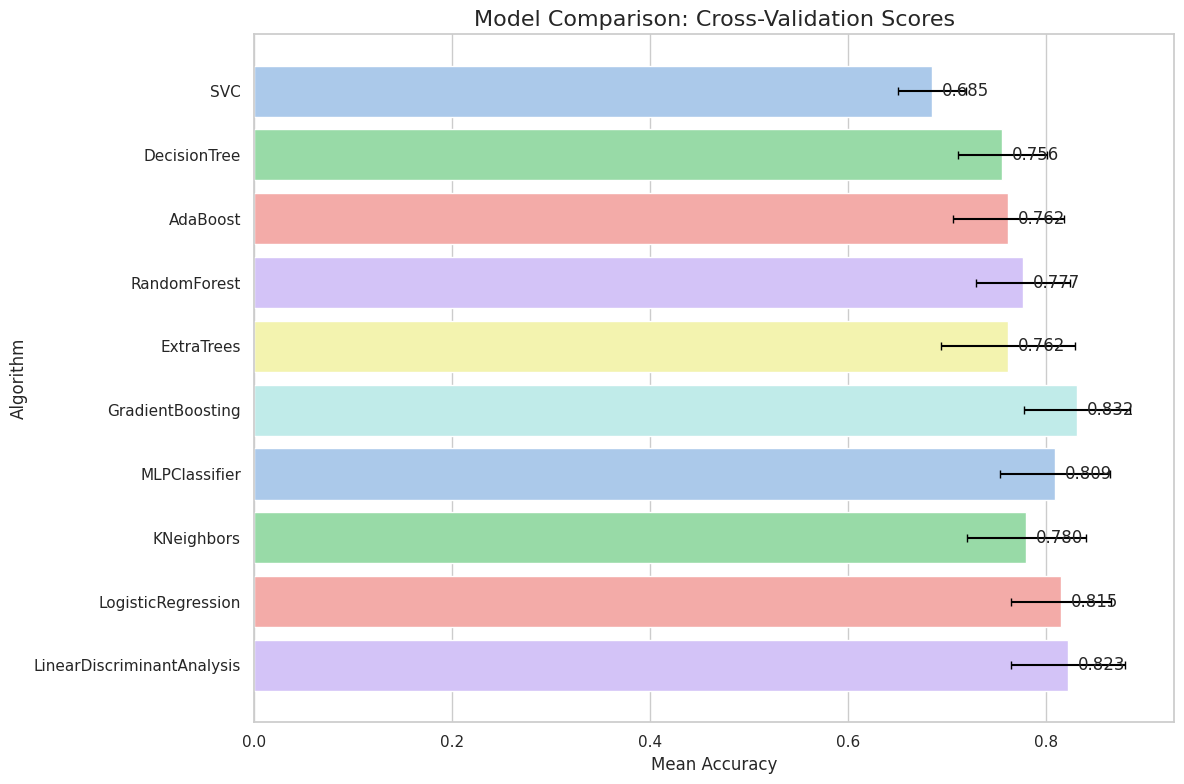

In [185]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the horizontal bar plot
ax = sns.barplot(x='CrossValMean', y='Algorithm', data=cv_results,
                 palette='pastel6', orient='h')

# Add error bars
ax.errorbar(x=cv_results['CrossValMean'], y=cv_results.index,
            xerr=cv_results['CrossValStd'], fmt='none', c='black', capsize=3)

# Customize the plot
plt.title('Model Comparison: Cross-Validation Scores', fontsize=16)
plt.xlabel('Mean Accuracy', fontsize=12)
plt.ylabel('Algorithm', fontsize=12)

# Add value labels to the end of each bar
for i, v in enumerate(cv_results['CrossValMean']):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center')

# Adjust the plot layout and display
plt.tight_layout()
plt.show()

In [186]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["log_loss","exponential"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


0.8136363636363635

In [187]:
GBC_best

GradientBoostingClassifier(loss='exponential', max_depth=4, max_features=0.3,
                           min_samples_leaf=100, n_estimators=300)

In [188]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

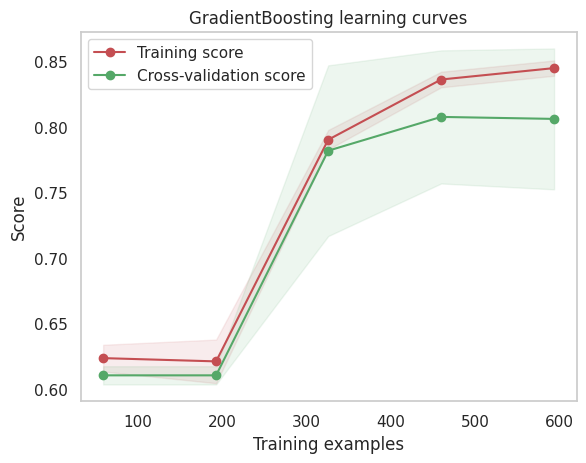

In [189]:
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

In [190]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 10, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8196969696969697

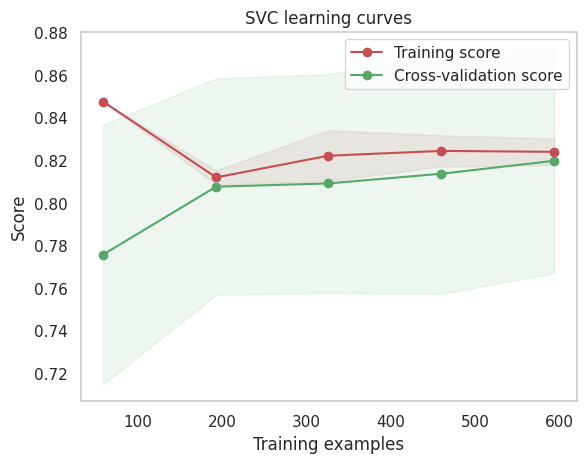

In [191]:
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)

In [192]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8227272727272726

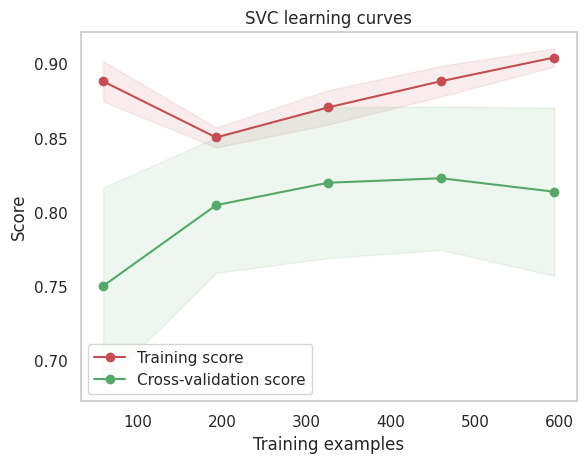

In [193]:
g = plot_learning_curve(gsRFC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)

In [194]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('svc', SVMC_best), ('gbc',GBC_best)], voting='soft', n_jobs=10)

votingC = votingC.fit(X_train, y_train)

In [195]:
votingC

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     n_estimators=300)),
                             ('svc', SVC(C=100, gamma=0.001, probability=True)),
                             ('gbc',
                              GradientBoostingClassifier(loss='exponential',
                                                         max_depth=4,
                                                         max_features=0.3,
                                                         min_samples_leaf=100,
                                                         n_estimators=300))],
                 n_jobs=10, voting='soft')